In [1]:
!pip install langchain
!pip install langchain_google_genai
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 41.4 MB/s eta 0:00:00


In [27]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=a1de9a1f9babdfde28760ec473d4f7f977019f4d313be773a320543c5299bf68
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [7]:
!pip install langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 3.9 MB/s eta 0:00:00


In [4]:
!pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 5.0 MB/s eta 0:00:00


In [38]:
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper,SearchApiAPIWrapper
from langchain_community.tools import WikipediaQueryRun
from langchain.schema.output_parser import StrOutputParser
from langchain.chains import LLMChain
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import CharacterTextSplitter
from langchain.document_loaders import TextLoader,PyPDFLoader
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain.prompts import ChatPromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain_groq import ChatGroq
from google.colab import userdata
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.checkpoint.memory import MemorySaver
api=userdata.get('groq_api_key')

llm =ChatGroq(
    api_key=api,
    model="mixtral-8x7b-32768",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [24]:
llm.invoke("make me laugh").content

"Sure, here's a joke for you:\n\nWhy couldn't the bicycle stand up by itself?\n\nBecause it was two-tired!\n\nI hope that made you laugh! Do you have any favorite jokes you'd like to share?"

In [30]:
wrapper_api = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
tools = WikipediaQueryRun(api_wrapper=wrapper_api)
tools.invoke("who is elon musk?")
tools.name

'wikipedia'

In [32]:
#start from here
#what is langgrapgh and how we can creat agent in langgraph
#in langgraph there are 4 main components
#FLOW
#NODES
#EDGES
#CONDITION


#class
#start node
#chatbot node
#tools node
#conditional_tool



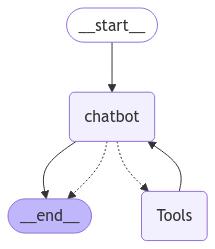

In [131]:
from logging import raiseExceptions
from threading import Condition
from typing import TypedDict, Annotated

# Define class
class State(TypedDict):
    messages : Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Bind LLM with the tools
llm_with_tools = llm.bind_tools(tools=[tools])

# Define chatbot function
def chatbot(State: State):
    return {"messages": llm_with_tools.invoke(State["messages"])}

# Add nodes to graph
graph_builder.add_node("chatbot", chatbot)

# Set up graph flow
graph_builder.add_edge(START, "chatbot")
tools_node = ToolNode(tools=[tools])
graph_builder.add_node("Tools", tools_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("Tools", "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph
graph = graph_builder.compile()

# Display the image (with proper exception handling)
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    raiseExceptions("Mermaid not properly configured.")


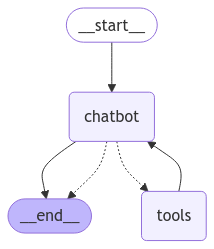

================================ Human Message =================================

write mathamatical equation fir euclidean formoula?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_7r1n)
 Call ID: call_7r1n
  Args:
    query: Euclidean distance formula
================================= Tool Message =================================
Name: wikipedia

Page: Euclidean distance
Summary: In mathematics, the Euclidean distance between two points in Euclidean space is the length of the line segment between them. It can be calculated from the Cartesian c
================================== Ai Message ==================================

The Euclidean distance between two points in a coordinate system is calculated using the formula:

d = √[(x2 - x1)² + (y2 - y1)²]

Where:
- d is the Euclidean distance
- x1 and y1 are the coordinates of the first point
- x2 and y2 are the coordinates of the second point

This formula is derived from t

In [141]:
#1:Langraph_application
from langgraph.prebuilt import ToolNode,tools_condition

class State(TypedDict):
  messages : Annotated[list,add_messages]  #append this message in the form of list

graph_builder = StateGraph(State)

#2: bind llm with the tools
llm_with_tools=llm.bind_tools(tools=[tools])


#3: define our chatbot
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

#entire flow of the execution
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot") #start node is connected with chabot
tool_node=ToolNode(tools=[tools])
graph_builder.add_node("tools",tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition  #bidirection itself with the chatbot
)
graph_builder.add_edge("tools","chatbot") #tools node is connected with chatbot
graph_builder.add_edge("chatbot",END) #end node is connected with tools

graph_built = graph_builder.compile()


from IPython.display import Image,display

try:
  display(Image(graph_built.get_graph().draw_mermaid_png()))
except:
  "you may have some error"



user_input = "write mathamatical equation fir euclidean formoula?"

events = graph_built.stream(
    {"messages" : [("user" , user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()
